# Australia Plauge Locust Modeling

This section covers the spatial modeling for australian plague locusts

- section 1: data management
- section 2: outbreak modeling
- section 3: nil-observatiom modeling
- section 4: outbreak and mean annual preciptation modeling

We will do basic modeling and saving relevant data to disk 

Another notebook later in the series will create mansucript figures and tables

# Section 1 - Data management

In [89]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("mgcv", "gratia", "sf","rnaturalearth",
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","tidyverse")

load_packages(packages)

i_am('README.md')


# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10,repr.matrix.max.rows=10)


here() starts at /home/datascience/herbivore_nutrient_interactions



## read in data

- filter species for APL
- manage data into long format
- select variables used for modeling
- create outbreak and nil observation datasets

In [90]:
apl_dat <- read_csv(here('data/processed/spatial_modeling/apl_survey_remote_sense_data.csv'),show_col_types = FALSE)

In [32]:
apl_locust_dat <- apl_dat |>
    clean_names() |>
  mutate(adult_density = str_remove_all(adult_density, "[{}]"),
         nymph_density = str_remove_all(nymph_density, "[{}]")) %>%
  separate_rows(adult_density, sep = ", ") %>%
  separate(adult_density, into = c("adult_density", "adult_density_count"), sep = ": ") %>%
  separate_rows(nymph_density, sep = ", ") %>%
  separate(nymph_density, into = c("nymph_density", "nymph_density_count"), sep = ": ") %>%
  mutate(across(c(adult_density, adult_density_count, nymph_density, nymph_density_count), as.numeric)) |> 
  distinct() |>
  group_by(polygon_id,species) |>
  mutate(total_observations = n()) 


In [4]:
unique(apl_locust_dat$ecoregion)

[1] "Great Victoria desert"                
 [2] "Central Ranges xeric scrub"           
 [3] "Tirari-Sturt stony desert"            
 [4] "Simpson desert"                       
 [5] "Great Sandy-Tanami desert"            
 [6] "Mitchell Grass Downs"                 
 [7] "Carpentaria tropical savanna"         
 [8] "Flinders-Lofty montane woodlands"     
 [9] "Murray-Darling woodlands and mallee"  
[10] "Southeast Australia temperate savanna"
[11] "Naracoorte woodlands"                 
[12] "Southeast Australia temperate forests"
[13] "Eastern Australia mulga shrublands"   
[14] "Brigalow tropical savanna"            
[15] "Eastern Australian temperate forests" 
[16] "Eyre and York mallee"

In [33]:
names(apl_locust_dat)

[1] "unnamed_0"                 "species"                  
 [3] "polygon_id"                "date"                     
 [5] "longitude"                 "latitude"                 
 [7] "data_quality"              "nymph_density"            
 [9] "nymph_density_count"       "adult_density"            
[11] "adult_density_count"       "data_quality_total_count" 
[13] "adult_density_total_count" "nymph_density_total_count"
[15] "geometry_x"                "x0_bdod_median"           
[17] "x10_silt_median"           "x1_cec_median"            
[19] "x2_cfvo_median"            "x3_clay_median"           
[21] "x4_nitrogen_median"        "x5_ocd_median"            
[23] "x6_ocs_single_band"        "x7_phh2o_median"          
[25] "x8_sand_median"            "x9_soc_median"            
[27] "awc_awc_000_005_ev"        "awc_awc_005_015_ev"       
[29] "bdw_bdw_000_005_ev"        "bdw_bdw_005_015_ev"       
[31] "cly_cly_000_005_ev"        "cly_cly_005_015_ev"       
[33] "ece_ece_000_005_ev"        "ece_ece_005_015_ev"       
[35] "nto_nto_000_005_ev"        "nto_nto_005_015_ev"       
[37] "pto_pto_000_005_ev"        "pto_pto_005_015_ev"       
[39] "slt_slt_000_005_ev"        "slt_slt_005_015_ev"       
[41] "snd_snd_000_005_ev"        "snd_snd_005_015_ev"       
[43] "soc_soc_000_005_ev"        "soc_soc_005_015_ev"       
[45] "bio01"                     "bio02"                    
[47] "bio03"                     "bio04"                    
[49] "bio05"                     "bio06"                    
[51] "bio07"                     "bio08"                    
[53] "bio09"                     "bio10"                    
[55] "bio11"                     "bio12"                    
[57] "bio13"                     "bio14"                    
[59] "bio15"                     "bio16"                    
[61] "bio17"                     "bio18"                    
[63] "bio19"                     "elevation"                
[65] "p_hc_p_hc_000_005_ev"      "p_hc_p_hc_005_015_ev"     
[67] "tree_canopy_cover"         "ecoregion"                
[69] "geometry_y"                "total_observations"

In [35]:
apl_outbreak_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 4) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev,ecoregion,bio12) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2,
          ecoregion = factor(ecoregion)) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev))  |>
    distinct()

apl_nil_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 0) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev,ecoregion,bio12) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2,
          ecoregion = factor(ecoregion)) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev)) |>
    distinct()

### save to disk for further use

In [36]:

write.csv(apl_outbreak_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),row.names=FALSE)

write.csv(apl_nil_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_nil_model_data.csv'),row.names=FALSE)


# Section 2 - outbreak modeling

In [48]:
outbreak_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),
                          show_col_types = FALSE) |>
    mutate(ecoregion = factor(ecoregion),nymph_density_count=as.integer(nymph_density_count)) |>
    #Filtering out extreme values
    filter(nymph_density_count <= 50 & nitrogen <= 0.4)  |>
    drop_na()

## Raw data visualization

In [49]:
head(outbreak_data,1)
nrow(outbreak_data)

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,ecoregion,bio12,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
162921,137.1195,-33.36002,4,1,1,Eyre and York mallee,331,0.07035461,0.02197414


[1] 6618

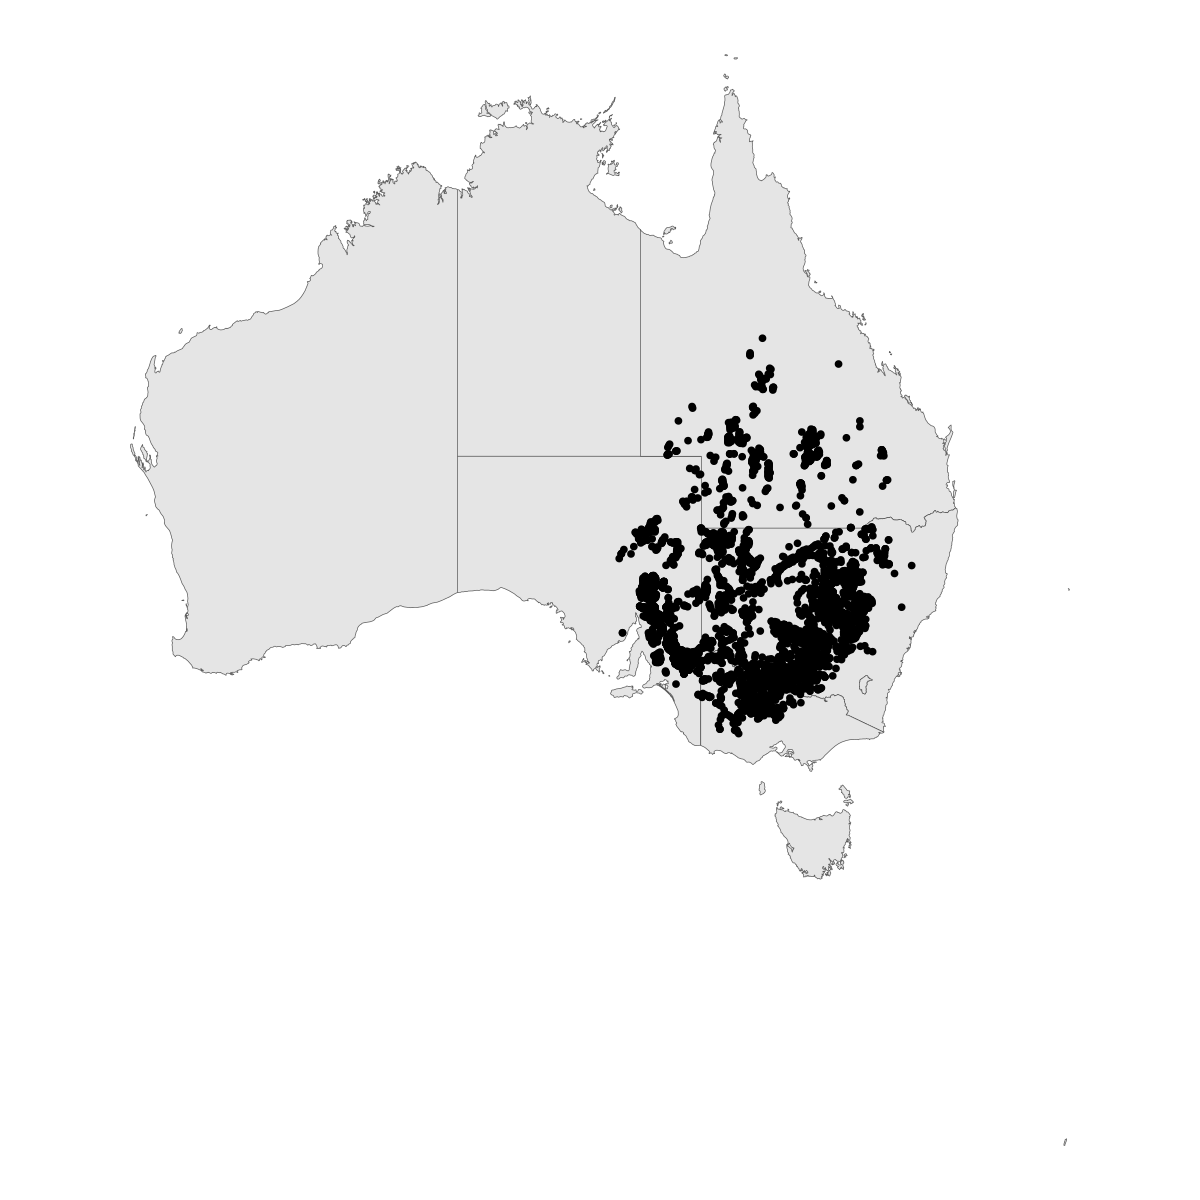

In [50]:
aus <- ne_states(country = 'Australia')


map_dat <- outbreak_data |>
    select(polygon_id,latitude,longitude,nymph_density_count) |>
    st_as_sf(coords = c('longitude','latitude'),
                   crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

outbreak_point_map <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat) +
        theme_void() 

outbreak_point_map

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


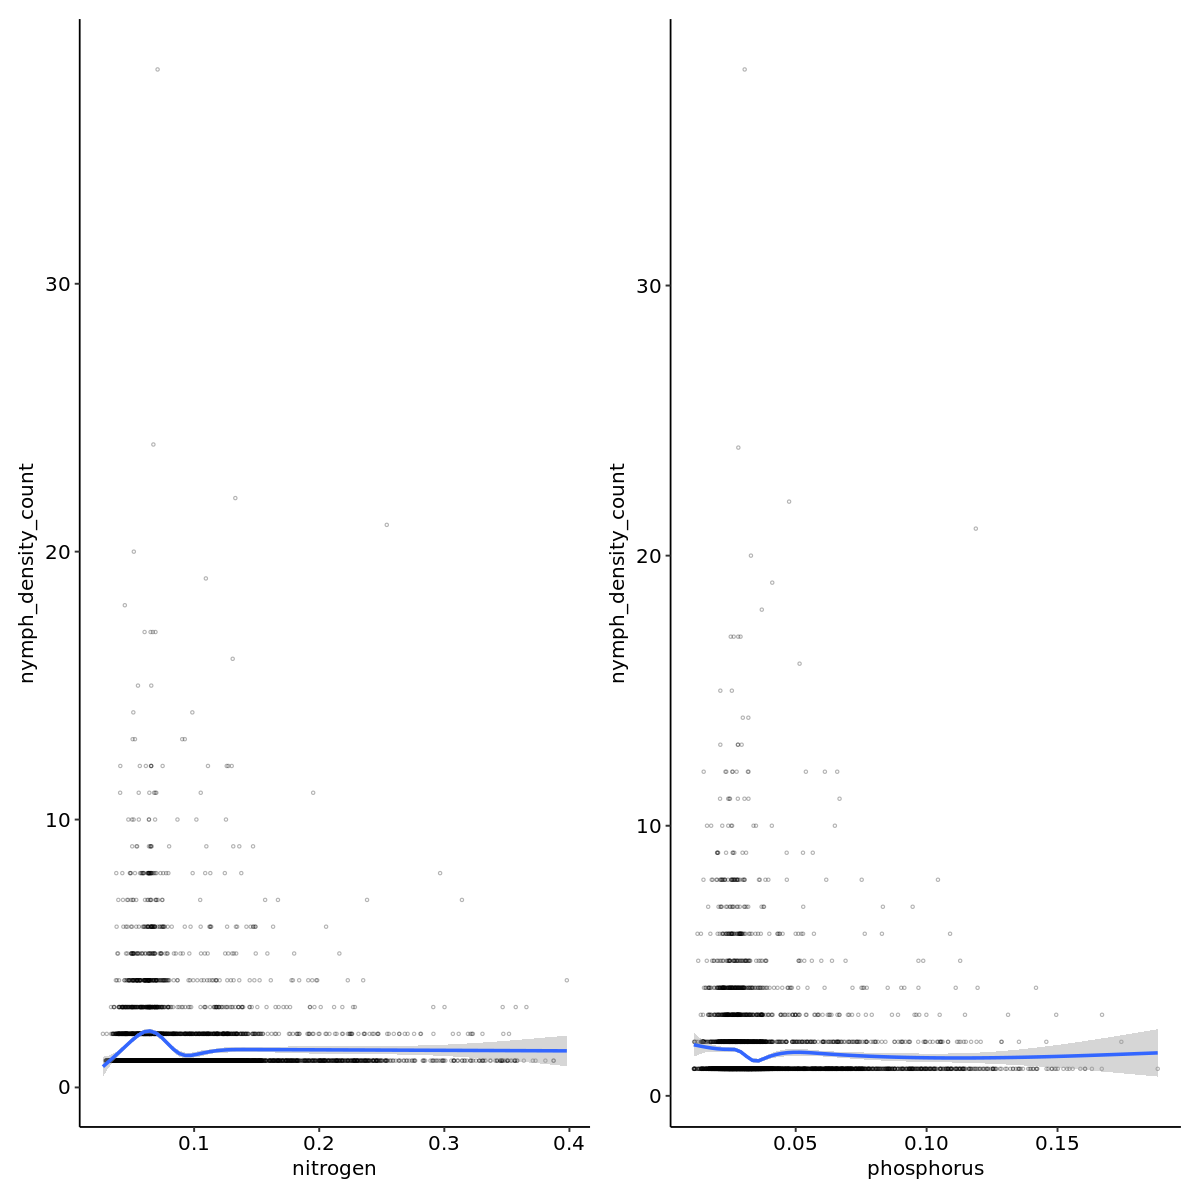

In [51]:
nto_plot <- outbreak_data |>
    ggplot(aes(x=nitrogen,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

pto_plot <- outbreak_data |>
    ggplot(aes(x=phosphorus,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

nto_plot + pto_plot

## Modeling

In [11]:
summary(outbreak_data)

   polygon_id        longitude        latitude      nymph_density
 Min.   : 162921   Min.   :137.0   Min.   :-37.57   Min.   :4    
 1st Qu.: 437649   1st Qu.:139.7   1st Qu.:-34.45   1st Qu.:4    
 Median :1009080   Median :143.0   Median :-32.53   Median :4    
 Mean   : 984545   Mean   :142.9   Mean   :-32.25   Mean   :4    
 3rd Qu.:1494243   3rd Qu.:146.0   3rd Qu.:-31.04   3rd Qu.:4    
 Max.   :2092645   Max.   :151.3   Max.   :-21.08   Max.   :4    
                                                                 
 nymph_density_count nymph_density_total_count
 Min.   : 1.000      Min.   :  1.000          
 1st Qu.: 1.000      1st Qu.:  1.000          
 Median : 1.000      Median :  1.000          
 Mean   : 1.555      Mean   :  2.382          
 3rd Qu.: 1.000      3rd Qu.:  2.000          
 Max.   :38.000      Max.   :205.000          
                                              
                                 ecoregion       nitrogen      
 Southeast Australia temperate s

In [52]:
outbreak_mod <- bam(nymph_density_count ~
               s(nitrogen,k=10,bs='tp') +
               s(phosphorus,k=10,bs='tp') +
               s(nymph_density_total_count,k=25,bs='tp') +
               te(longitude,latitude,bs=c('gp','gp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = outbreak_data)

Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”


In [53]:
summary(outbreak_mod)


Family: Tweedie(p=1.99) 
Link function: log 

Formula:
nymph_density_count ~ s(nitrogen, k = 10, bs = "tp") + s(phosphorus, 
    k = 10, bs = "tp") + s(nymph_density_total_count, k = 25, 
    bs = "tp") + te(longitude, latitude, bs = c("gp", "gp"), 
    k = 25) + s(ecoregion, bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.55154    0.03495   44.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                edf Ref.df       F p-value    
s(nitrogen)                   6.273      9  25.620  <2e-16 ***
s(phosphorus)                 5.372      9  15.521  <2e-16 ***
s(nymph_density_total_count) 22.547     24 630.896  <2e-16 ***
te(longitude,latitude)       56.140    529   1.148  0.0123 *  
s(ecoregion)                  6.498     10   4.802  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.769   D

## Model Diagnostics 

In [54]:
k.check(outbreak_mod)

,k',edf,k-index,p-value
s(nitrogen),9,6.273422,0.9868934,0.300
s(phosphorus),9,5.372169,1.0170037,0.955
s(nymph_density_total_count),24,22.547306,0.9573451,0.000
"te(longitude,latitude)",624,56.140461,0.8768059,0.000
s(ecoregion),11,6.498451,NA,NA


In [55]:
concurvity(outbreak_mod,full=FALSE)

,para,s(nitrogen),s(phosphorus),s(nymph_density_total_count),"te(longitude,latitude)",s(ecoregion)
para,1.0000000,0.6883534,0.7490074,0.9880373,1.0000000,1.0000000
s(nitrogen),0.6883534,1.0000000,0.8558808,0.7209855,0.8334426,0.7424998
s(phosphorus),0.7490074,0.8558808,1.0000000,0.7990995,0.8208353,0.7555303
s(nymph_density_total_count),0.9880373,0.7209855,0.7990995,1.0000000,0.9890154,0.9883096
"te(longitude,latitude)",1.0000000,0.8334425,0.8208353,0.9890154,1.0000000,1.0000000
s(ecoregion),1.0000000,0.7424998,0.7555303,0.9883096,1.0000000,1.0000000
,para,s(nitrogen),s(phosphorus),s(nymph_density_total_count),"te(longitude,latitude)",s(ecoregion)
para,1.0000000,0.5276437,0.7365579,0.9079395,0.01051500,0.01358394
s(nitrogen),0.6883534,1.0000000,0.8458158,0.7027435,0.53716791,0.09132533
s(phosphorus),0.7490074,0.7118931,1.0000000,0.7820410,0.03677412,0.04454272


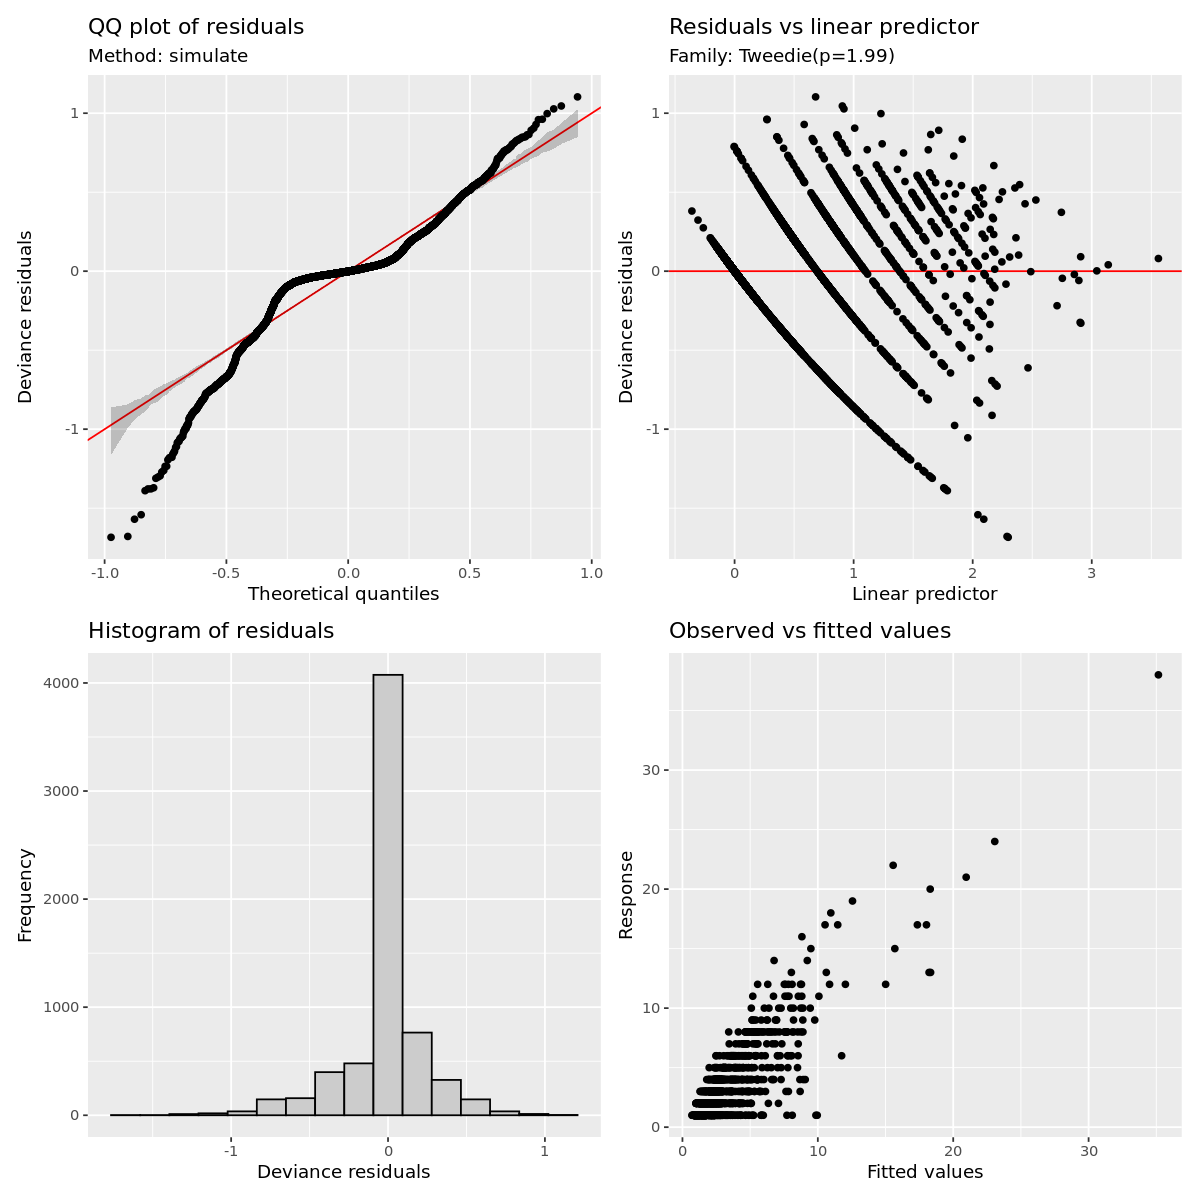

In [56]:
gratia::appraise(outbreak_mod)

## Quick model visualization

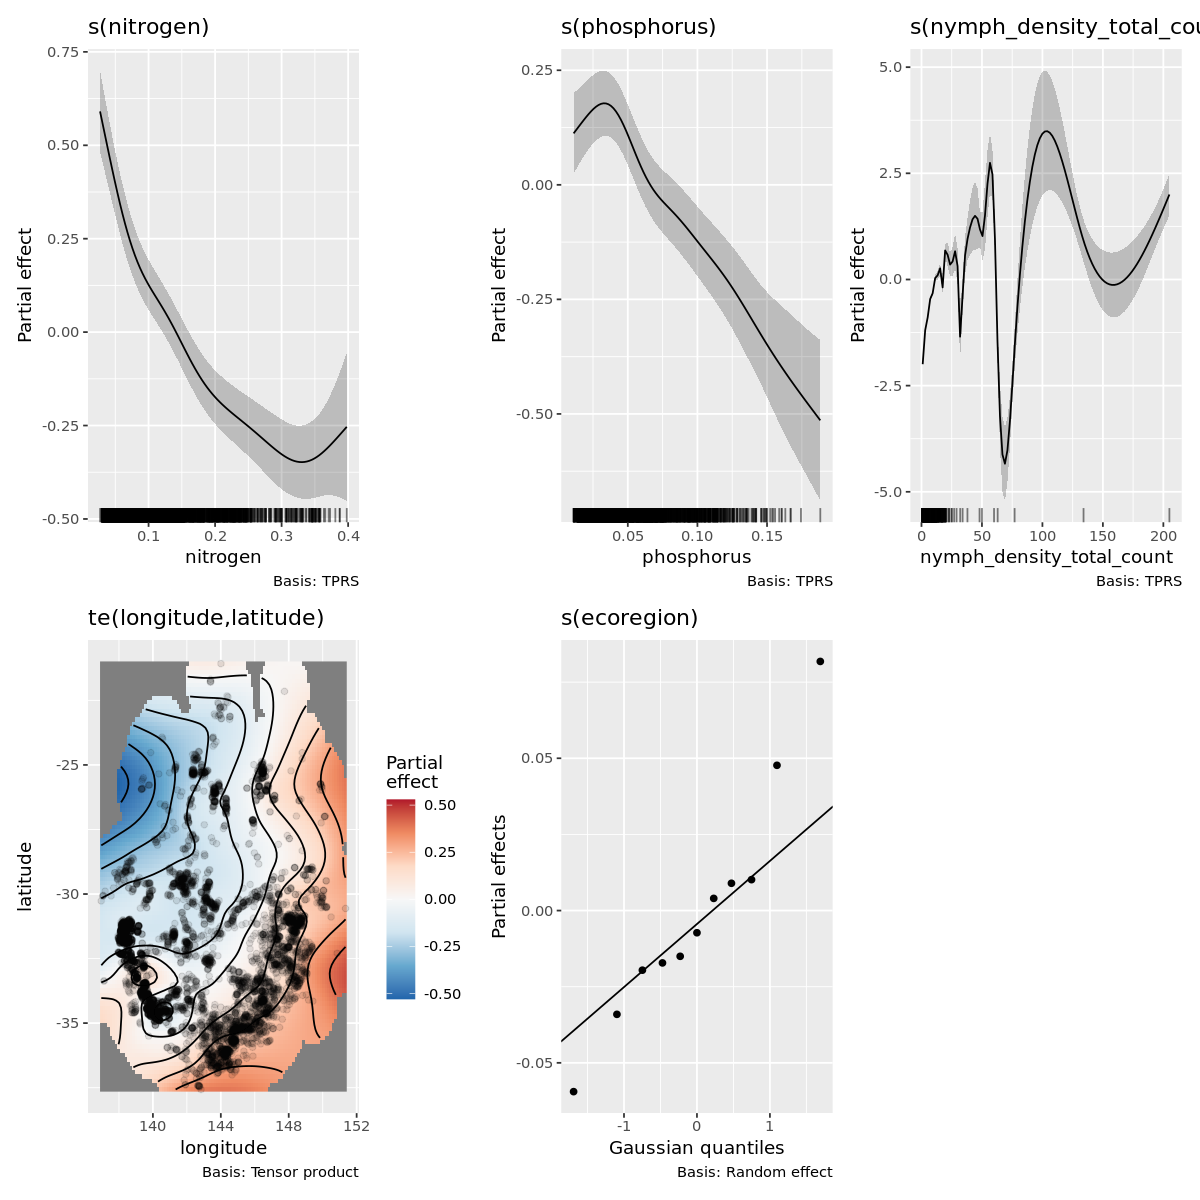

In [57]:
gratia::draw(outbreak_mod)

## Outbreak modeling evaluation

Its obvious this model has some fitting issues, espicially with lower values of the dependent variable. 

This is likely correlational issues between all the variable and it can muddy the interpretation as well as the number of 1 off observations. 

I have already filtered out extreme grid cells that have more than 50 obersvations and that did improve the fit more. 



## saving outputs

In [58]:
saveRDS(outbreak_mod, here("output/spatial_modeling/model_objects/locust_outbreak_model.rds"))

In [86]:
outbreak_model_smooth_estimates <- smooth_estimates(outbreak_mod,dist=0.1)

write.csv(outbreak_model_smooth_estimates, here("output/spatial_modeling/outbreak_model_smooth_estimates.csv"),row.names=FALSE)


In [84]:
outbreak_model_smooth_estimates <- smooth_estimates(outbreak_mod,dist=0.1)

In [71]:
outbreak_model_smooth_estimates

.smooth,.type,.by,.estimate,.se,nitrogen,phosphorus,nymph_density_total_count,longitude,latitude,ecoregion
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
s(nitrogen),TPRS,NA,0.05056327,0.02819440,0.02262577,NA,NA,NA,NA,NA
s(nitrogen),TPRS,NA,0.05127533,0.02774333,0.02643393,NA,NA,NA,NA,NA
s(nitrogen),TPRS,NA,0.05198999,0.02732688,0.03024208,NA,NA,NA,NA,NA
s(nitrogen),TPRS,NA,0.05271331,0.02694706,0.03405024,NA,NA,NA,NA,NA
s(nitrogen),TPRS,NA,0.05345310,0.02660461,0.03785840,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s(ecoregion),Random effect,NA,-0.0002120522,0.005155784,NA,NA,NA,NA,NA,Naracoorte woodlands
s(ecoregion),Random effect,NA,-0.0002261551,0.004471238,NA,NA,NA,NA,NA,Simpson desert
s(ecoregion),Random effect,NA,0.0014202656,0.004640904,NA,NA,NA,NA,NA,Southeast Australia temperate forests


# section 3: nil-observatiom modeling

In [60]:
nil_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_nil_model_data.csv'),
                          show_col_types = FALSE)  |>
    mutate(ecoregion = factor(ecoregion),nymph_density_count=as.integer(nymph_density_count)) |>
    #Filtering out extreme values
    filter(nymph_density_count <= 50 & nitrogen <= 0.4)  |>
    drop_na()

nil_data

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,ecoregion,bio12,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
7280,133.4553,-27.06065,0,1,1,Central Ranges xeric scrub,208,0.03300749,0.02376515
8026,133.2392,-26.40242,0,1,1,Central Ranges xeric scrub,225,0.03097755,0.01831567
8097,133.2565,-26.49929,0,1,1,Central Ranges xeric scrub,223,0.03094262,0.01980745
13279,133.7368,-27.45913,0,1,1,Great Victoria desert,190,0.03268851,0.02072279
13512,133.8018,-27.53024,0,2,2,Tirari-Sturt stony desert,191,0.03296471,0.01975296
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2099638,151.0890,-27.07120,0,1,1,Brigalow tropical savanna,647,0.1090968,0.05359124
2100024,151.1908,-27.21150,0,1,1,Brigalow tropical savanna,650,0.1135198,0.06566815
2100282,151.2569,-27.43300,0,1,1,Brigalow tropical savanna,628,0.1068338,0.06458026


## Raw data visualization

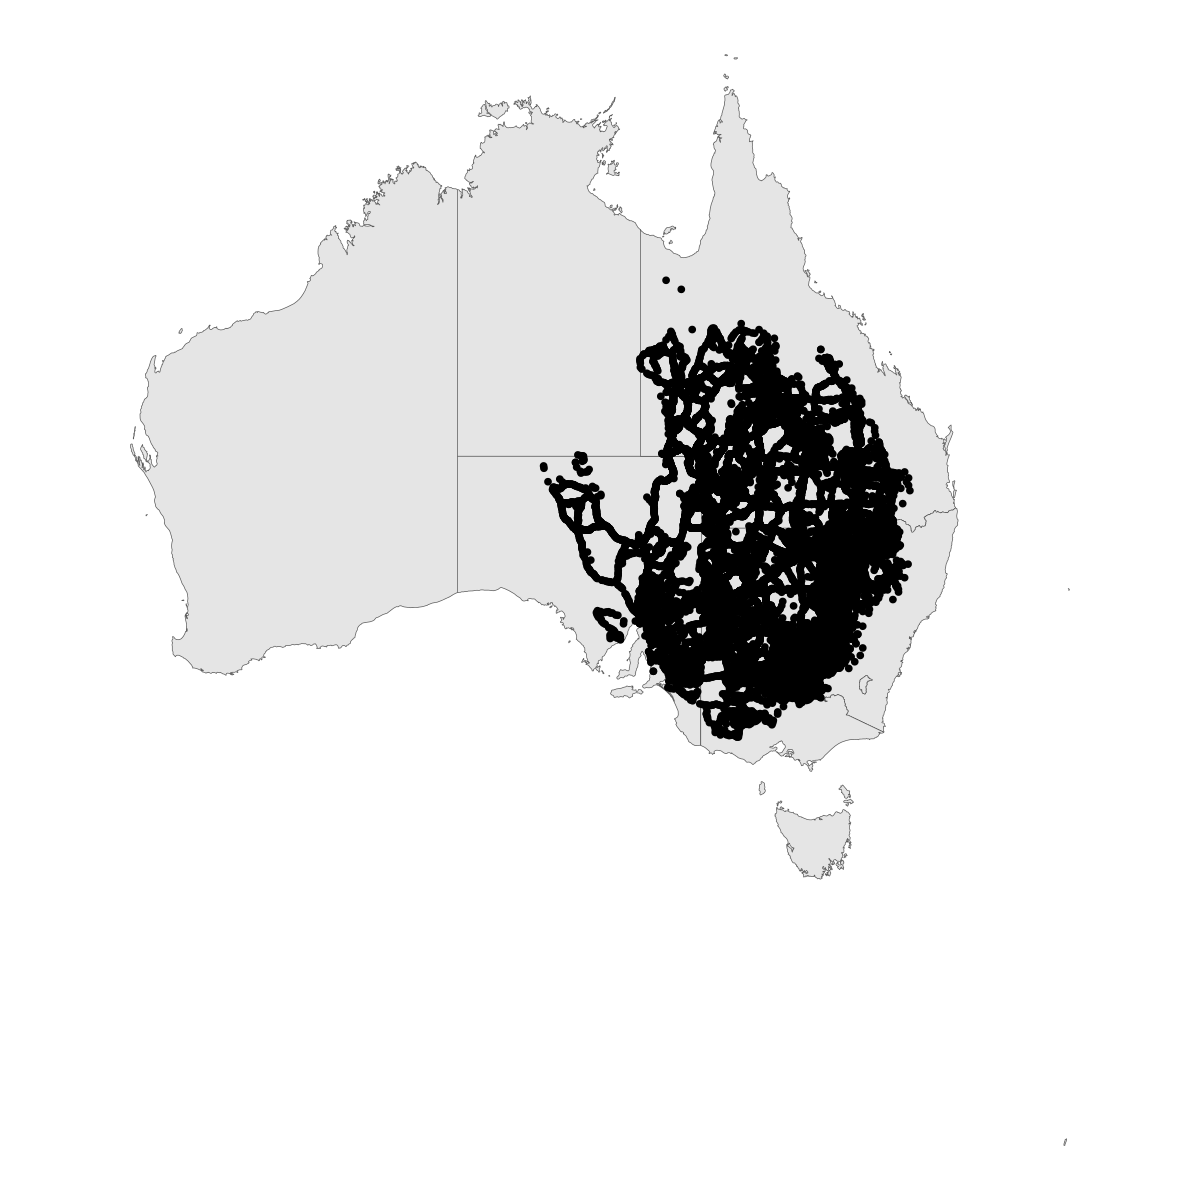

In [61]:
aus <- ne_states(country = 'Australia')


map_dat <- nil_data |>
    select(polygon_id,latitude,longitude,nymph_density_count) |>
    st_as_sf(coords = c('longitude','latitude'),
                   crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

nil_point_map <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat) +
        theme_void() 

nil_point_map

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


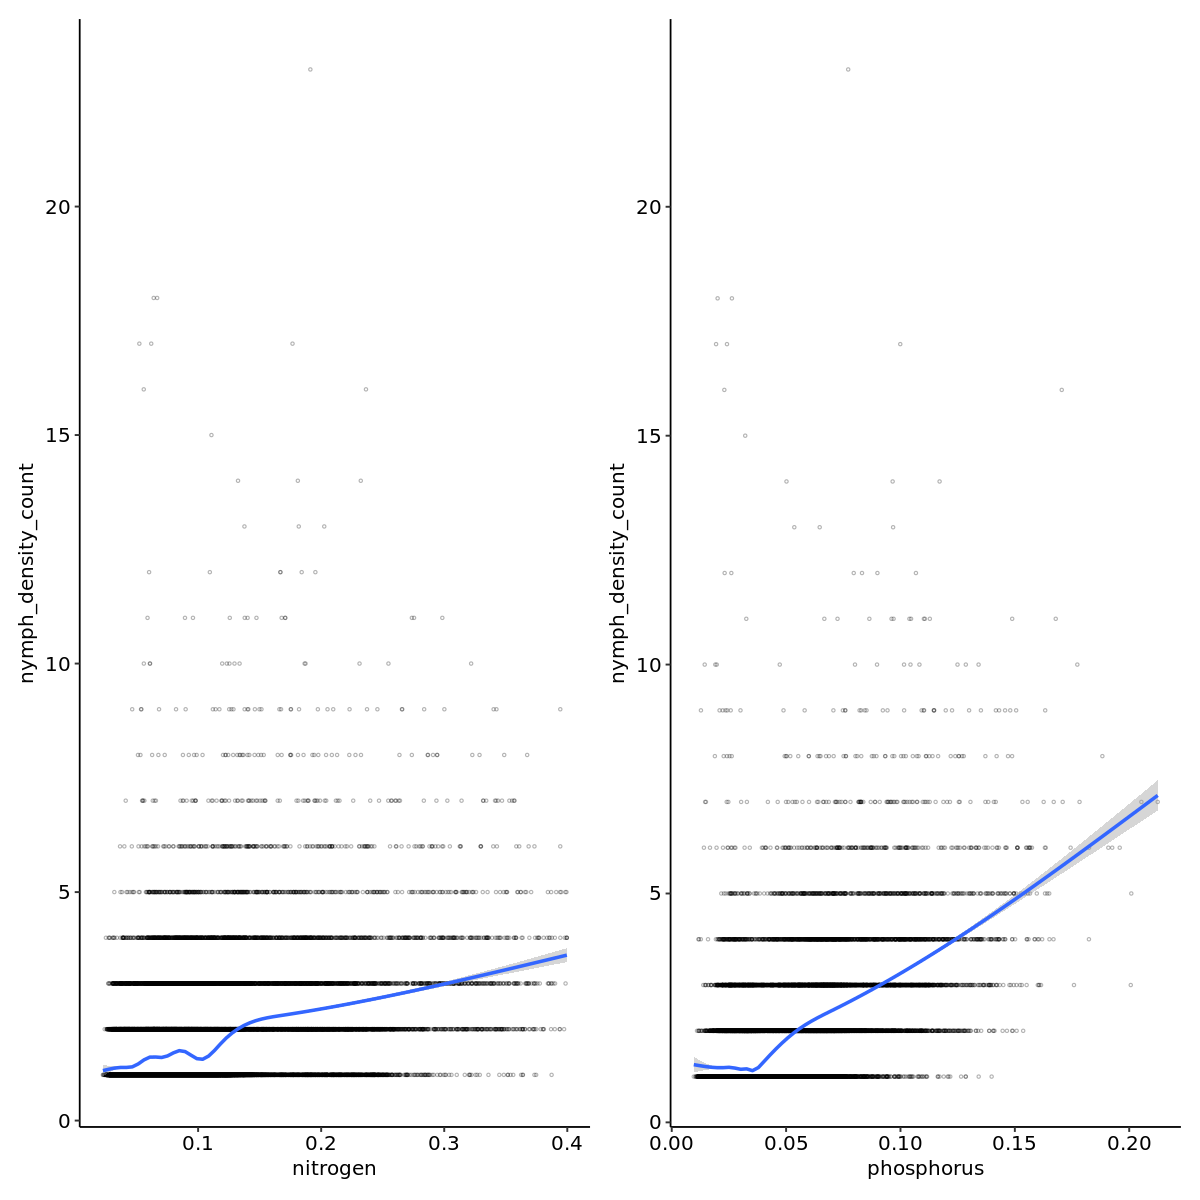

In [62]:
nto_plot <- nil_data |>
    ggplot(aes(x=nitrogen,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

pto_plot <- nil_data |>
    ggplot(aes(x=phosphorus,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

nto_plot + pto_plot

## Modeling

In [63]:
nil_mod <- bam(nymph_density_count ~
               s(nitrogen,k=10,bs='tp') +
               s(phosphorus,k=10,bs='tp') +
               s(nymph_density_total_count,k=25,bs='tp') +
               te(longitude,latitude,bs=c('gp','gp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nil_data)

Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”


## Model diagnostics

In [64]:
k.check(nil_mod)

,k',edf,k-index,p-value
s(nitrogen),9,6.426332,0.9719328,0.0425
s(phosphorus),9,6.406880,0.9658401,0.0150
s(nymph_density_total_count),24,22.408362,0.9912682,0.3475
"te(longitude,latitude)",624,131.476046,0.9515954,0.0050
s(ecoregion),15,2.726108,NA,NA


In [65]:
concurvity(nil_mod,full=FALSE)

,para,s(nitrogen),s(phosphorus),s(nymph_density_total_count),"te(longitude,latitude)",s(ecoregion)
para,1.0000000,0.8307967,0.8685621,0.9974470,1.0000000,1.0000000
s(nitrogen),0.8307967,1.0000000,0.9004807,0.8637565,0.8800706,0.8556794
s(phosphorus),0.8685621,0.9004807,1.0000000,0.9113526,0.8792777,0.8697074
s(nymph_density_total_count),0.9974470,0.8637565,0.9113526,1.0000000,0.9975198,0.9974679
"te(longitude,latitude)",1.0000000,0.8800708,0.8792781,0.9975198,1.0000000,1.0000000
s(ecoregion),1.0000000,0.8556794,0.8697074,0.9974679,1.0000000,1.0000000
,para,s(nitrogen),s(phosphorus),s(nymph_density_total_count),"te(longitude,latitude)",s(ecoregion)
para,1.0000000,0.7868098,0.8083066,0.8551952,0.004546396,0.06430443
s(nitrogen),0.8307967,1.0000000,0.8181989,0.8397272,0.044026705,0.14027235
s(phosphorus),0.8685621,0.8614793,1.0000000,0.9002601,0.061211576,0.17528098


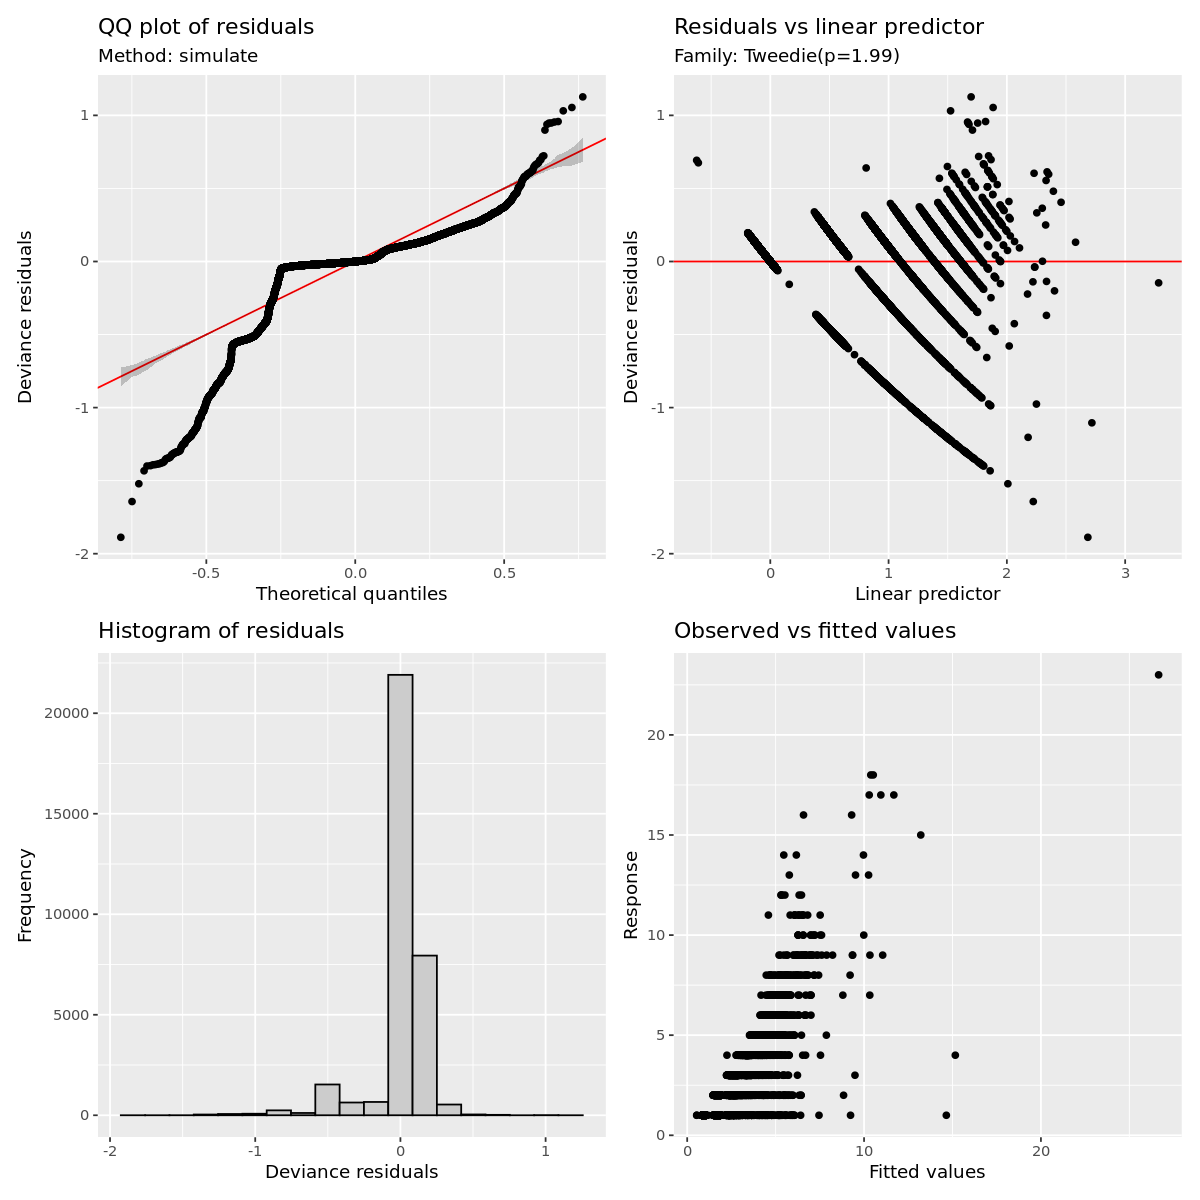

In [66]:
gratia::appraise(nil_mod)

In [67]:
summary(nil_mod)


Family: Tweedie(p=1.99) 
Link function: log 

Formula:
nymph_density_count ~ s(nitrogen, k = 10, bs = "tp") + s(phosphorus, 
    k = 10, bs = "tp") + s(nymph_density_total_count, k = 25, 
    bs = "tp") + te(longitude, latitude, bs = c("gp", "gp"), 
    k = 25) + s(ecoregion, bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.43919    0.02338   61.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                 edf Ref.df        F p-value    
s(nitrogen)                    6.426      9   35.340  <2e-16 ***
s(phosphorus)                  6.407      9   28.867  <2e-16 ***
s(nymph_density_total_count)  22.408     24 3199.357  <2e-16 ***
te(longitude,latitude)       131.476    557    3.302  <2e-16 ***
s(ecoregion)                   2.726     14    0.361  0.0352 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) 

## Quick modeling visualization

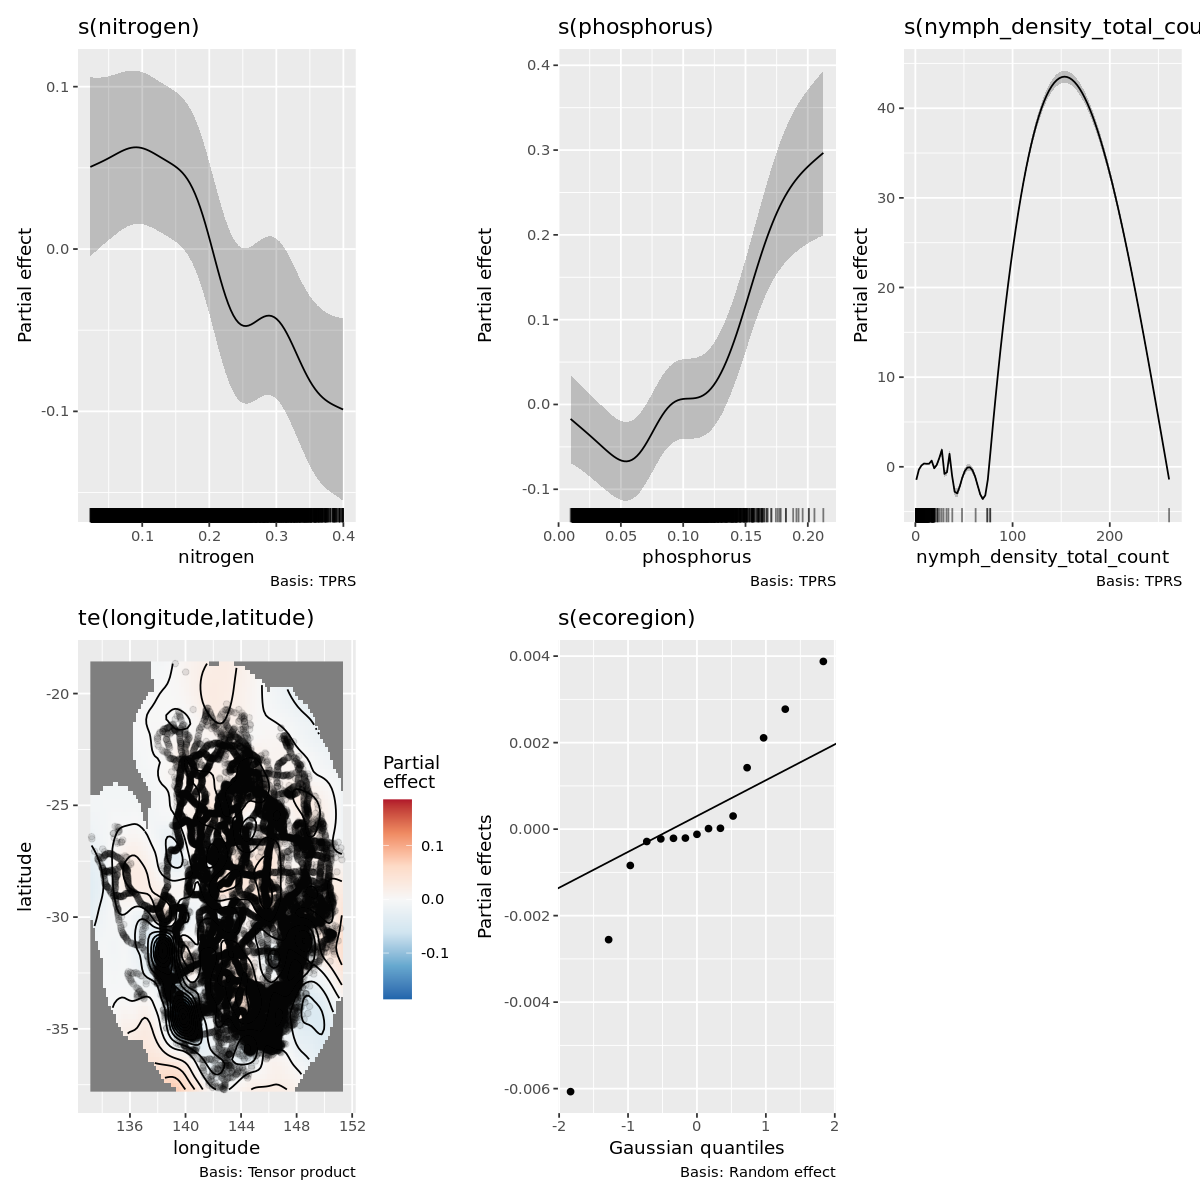

In [68]:
gratia::draw(nil_mod)

## saving outputs

In [69]:
saveRDS(nil_mod, here("output/spatial_modeling/model_objects/locust_nil_model.rds"))

In [87]:
outbreak_model_smooth_estimates <- smooth_estimates(nil_mod,dist=0.1)

write.csv(outbreak_model_smooth_estimates, here("output/spatial_modeling/nil_model_smooth_estimates.csv"),row.names=FALSE)


# Section 4 - Locust outbreaks and mean annual preciptation modeling

## Modeling

In [39]:

nil_data

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,ecoregion,bio12,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
7280,133.4553,-27.06065,0,1,1,Central Ranges xeric scrub,208,0.03300749,0.02376515
8026,133.2392,-26.40242,0,1,1,Central Ranges xeric scrub,225,0.03097755,0.01831567
8097,133.2565,-26.49929,0,1,1,Central Ranges xeric scrub,223,0.03094262,0.01980745
13279,133.7368,-27.45913,0,1,1,Great Victoria desert,190,0.03268851,0.02072279
13512,133.8018,-27.53024,0,2,2,Tirari-Sturt stony desert,191,0.03296471,0.01975296
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2099638,151.0890,-27.07120,0,1,1,Brigalow tropical savanna,647,0.1090968,0.05359124
2100024,151.1908,-27.21150,0,1,1,Brigalow tropical savanna,650,0.1135198,0.06566815
2100282,151.2569,-27.43300,0,1,1,Brigalow tropical savanna,628,0.1068338,0.06458026


In [40]:
outbreak_map_mod <- bam(nymph_density_count ~
               s(bio12,bs='tp',k=10) +
               s(nymph_density_total_count,k=25,bs='tp') +
               te(longitude,latitude,bs=c('gp','gp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = outbreak_data)

nil_map_mod <- bam(nymph_density_count ~
               s(bio12,bs='tp',k=10) +
               s(nymph_density_total_count,k=25,bs='tp') +
               te(longitude,latitude,bs=c('gp','gp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nil_data)

Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”
Warning message in estimate.theta(theta, family, y, mu, scale = scale1, wt = G$w, :
“step failure in theta estimation”


## saving outputs

In [41]:
saveRDS(outbreak_map_mod, here("output/spatial_modeling/model_objects/locust_outbreak_map_model.rds"))
saveRDS(nil_map_mod, here("output/spatial_modeling/model_objects/locust_nil_map_model.rds"))

In [88]:
map_outbreak_model_smooth_estimates <- smooth_estimates(outbreak_map_mod,dist=0.1)
map_nill_model_smooth_estimates <- smooth_estimates(nil_map_mod,dist=0.1)

write.csv(map_outbreak_model_smooth_estimates, here("output/spatial_modeling/map_outbreak_model_smooth_estimates.csv"),row.names=FALSE)
write.csv(map_nill_model_smooth_estimates, here("output/spatial_modeling/map_nill_model_smooth_estimates.csv"),row.names=FALSE)
